In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import cvxpy as cp
import matplotlib.pyplot as plt

FIGURES_DIR = PROJECT_DIR + '/output/figures'

In [251]:
PROJECT_DIR = '/Users/joseivelarde/Projects/aii-design'
FIGURES_DIR = PROJECT_DIR + '/output/figures'
TABLES_DIR = PROJECT_DIR + '/output/tables'
def make_single_zone_data(beta,mu,sigma,n=100):
    theta = np.random.normal(loc=mu,scale=sigma,size=n)
    epsilon = np.random.normal(loc=0,scale=1)
    w = beta*theta + epsilon
    return w, theta.reshape(-1,1)

In [165]:
def min_premium_program(pred_y,train_y,loss_p,epsilon,model='full',a_lb=0):
    w_bar = np.quantile(train_y,loss_p)
    n_samples = train_y.shape[0]
    I = cp.Variable(n_samples)
    a = cp.Variable()
    b = cp.Variable()
    t = cp.Variable()
    gamma = cp.Variable(n_samples)

    constraints = []
    constraints.append(I >= 0)
    constraints.append(t + (1/epsilon)*(1/n_samples)*(sum(gamma))<= w_bar)
    constraints.append(gamma >=  pred_y + (1/n_samples)*sum(I) - I -t)
    constraints.append(gamma >= 0)
    
    if model == 'full':
        constraints.append(I >= a*pred_y + b)
        constraints.append(b <= 0)
        constraints.append(a >= a_lb)
    elif model == 'slope':
        constraints.append(I >= a*pred_y)
        constraints.append(a >= a_lb)
    else:
        constraints.append(I >= pred_y + b)
        constraints.append(b <= 0)

    objective = cp.Minimize(sum(I))
    problem = cp.Problem(objective,constraints)
    problem.solve()
    print(problem.status)
    return_dict = {'full':(a.value,b.value),'slope':(a.value,0),'intercept':(1,b.value)}
    return return_dict[model]

In [278]:
def min_CVaR_program(pred_y,train_y,max_pi,epsilon,model='full',a_lb=0):
    n_samples = train_y.shape[0]
    I = cp.Variable(n_samples)
    a = cp.Variable()
    b = cp.Variable()
    t = cp.Variable()
    max_payout = cp.Variable()
    gamma = cp.Variable(n_samples)

    constraints = []
    constraints.append(I >= 0)
    constraints.append(I <= max_payout)
    constraints.append((1/n_samples)*sum(I) <= max_pi*max_payout)
    constraints.append(gamma >=  pred_y + (1/n_samples)*sum(I) - I -t)
    constraints.append(gamma >= 0)
    
    if model == 'full':
        constraints.append(I >= a*pred_y + b)
        constraints.append(b <= 0)
        constraints.append(a >= a_lb)
    elif model == 'slope':
        constraints.append(I >= a*pred_y)
        constraints.append(a >= a_lb)
    else:
        constraints.append(I >= pred_y + b)
        constraints.append(b <= 0)

    objective = cp.Minimize(t + (1/epsilon)*(1/n_samples)*(sum(gamma)))
    problem = cp.Problem(objective,constraints)
    problem.solve()
    return_dict = {'full':(a.value,b.value),'slope':(a.value,0),'intercept':(1,b.value)}
    return return_dict[model] 

In [250]:
def determine_strike_value(train_y,eval_y,eval_x,pred_model):
    strike_percentiles = np.arange(0.1,0.35,0.05)
    strike_vals = np.quantile(train_y,strike_percentiles)
    
    pred_losses = pred_model.predict(eval_x)
    strike_performance = {}

    for strike_percentile, strike_val in zip(strike_percentiles,strike_vals):
        strike_percentile = np.around(strike_percentile,2)
        insured_loss = np.maximum(eval_y-strike_val,0)
        payout = np.maximum(pred_losses-strike_val,0).reshape(-1,1)
        loss_share_model = LinearRegression().fit(payout,insured_loss)
        share_explained = loss_share_model.coef_[0]
        strike_performance[(strike_percentile,strike_val)] = share_explained

    best_strike_percentile, best_strike_val = max(strike_performance,key=strike_performance.get)
    return best_strike_percentile, best_strike_val

def make_eval_dfs(test_x,test_y,pred_model,strike_val,a,b):
    loss_quantiles = np.quantile(test_y,[0.7,0.8,0.9,0.95])
    col_names = ['P(L > {})'.format(i) for i in [70,80,90,95]]
    
    bdf = pd.DataFrame()
    odf = pd.DataFrame()
    bdf['Losses'] = test_y
    bdf['PredictedLosses'] = pred_model.predict(test_x)
    bdf['Payout'] = np.maximum(bdf['PredictedLosses']-strike_val,0)
    bdf['NetLoss'] = bdf['Losses'] - bdf['Payout']
    
    odf['Losses'] = test_y
    odf['PredictedLosses'] = pred_model.predict(test_x)
    odf['Payout'] = np.maximum(a*odf['PredictedLosses']+b,0)
    odf['NetLoss'] = odf['Losses']-odf['Payout']
    
    for col_name, loss_quantile in zip(col_names,loss_quantiles):
        bdf[col_name] = bdf['NetLoss'] > loss_quantile
        odf[col_name] = odf['NetLoss'] > loss_quantile
    odf = odf.rename(columns={'Payout':'Premium'})
    bdf = bdf.rename(columns={'Payout':'Premium'})
    return bdf, odf

In [277]:
def plot_payout_functions(bdf,odf,fig_dir):
    plt.plot(bdf['PredictedLosses'],bdf['Payout'],'bs',label='baseline')
    plt.plot(odf['PredictedLosses'],odf['Payout'],'g^',label='opt')
    plt.title('epsilon: {}, q: {}'.format(epsilon,loss_quantile))
    plt.text(3,15,'a = {}, b = {}'.format(a,b))
    plt.legend()
    filename = fig_dir + '/e_{}_q_{}.png'.format(epsilon*100,loss_quantile*200)
    plt.savefig(filename)
    plt.close()
    
def plot_payout_functions2(ax,bdf,odf,a,b,args):
    ax.plot(bdf['PredictedLosses'],bdf['Premium'],'bs',label='baseline')
    ax.plot(odf['PredictedLosses'],odf['Premium'],'g^',label='opt')
    ax.set_title('{}: {}, {}: {}'.format(*args))
    ax.text(3,15,'a = {}, b = {}'.format(a,b))
    ax.legend()

def premium_program_exploration(model):
    train_y, train_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=100)
    eval_y, eval_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=20)
    test_y, test_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=1000)

    pred_model = LinearRegression().fit(train_x,train_y)
    model_predictions = pred_model.predict(train_x)
    strike_p, strike_val = determine_strike_value(train_y,eval_y,eval_x,pred_model)
    
    fig_dir = FIGURES_DIR + '/Premium Model'
    table_dir = TABLES_DIR + '/Premium Model'
    
#     loss_quantile exploration
    epsilon = 0.2
    loss_quantiles = np.around(np.linspace(0.55,0.9,5),3)
    fig, axes = plt.subplots(5,1,figsize=(10,10))
    ldf = pd.DataFrame()
    for loss_q,ax in zip(loss_quantiles,axes.ravel()):
        a,b = min_premium_program(model_predictions,train_y,loss_q,epsilon,model)
        a,b = np.around((a,b),2)
        bdf, odf = make_eval_dfs(test_x,test_y,pred_model,strike_val,a,b)
        plot_payout_functions2(ax,bdf,odf,a,b,loss_q,epsilon)
        
        opt_stats = odf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        opt_stats['Loss q'] = str(loss_q)
        ldf = ldf.append(opt_stats,ignore_index=True)
        
        base_stats = bdf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        base_stats['Loss q'] = 'Baseline'
        ldf = ldf.append(base_stats,ignore_index=True)
                         
    plt.tight_layout()
    filename = fig_dir+'/loss_q_exploration_{}.png'.format(model)
    plt.savefig(filename)
    
    table_filename = table_dir +'/loss_q_exploration_{}.tex'.format(model)
    ldf.drop_duplicates().sort_values('Loss q').to_latex(table_filename,float_format='%.2f')
                         
#     epsilon exploration
    epsilons = np.linspace(0.05,0.5,5)
    loss_quantile = 0.6
    fig, axes = plt.subplots(5,1,figsize=(10,10))
    ldf = pd.DataFrame()
    for eps,ax in zip(epsilons,axes.ravel()):
        a,b = min_premium_program(model_predictions,train_y,loss_quantile,eps,model)
        a,b = np.around((a,b),2)
        bdf, odf = make_eval_dfs(test_x,test_y,pred_model,strike_val,a,b)
        plot_payout_functions2(ax,bdf,odf,a,b,loss_quantile,eps)
        
        opt_stats = odf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        opt_stats['Eps'] = str(eps)
        ldf = ldf.append(opt_stats,ignore_index=True)
        
        base_stats = bdf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        base_stats['Eps'] = 'Baseline'
        ldf = ldf.append(base_stats,ignore_index=True)
                         
    plt.tight_layout()
    filename = fig_dir+'/epsilon_exploration_{}.png'.format(model)
    plt.savefig(filename)
    
    table_filename = table_dir +'/epsilon_exploration_{}.tex'.format(model)
    ldf.drop_duplicates().sort_values('Eps').to_latex(table_filename,float_format='%.2f')

In [294]:
def CVaR_program_exploration(model):
    train_y, train_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=100)
    eval_y, eval_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=20)
    test_y, test_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=1000)

    pred_model = LinearRegression().fit(train_x,train_y)
    model_predictions = pred_model.predict(train_x)
    strike_p, strike_val = determine_strike_value(train_y,eval_y,eval_x,pred_model)
    
    fig_dir = FIGURES_DIR + '/CVaR2'
    table_dir = TABLES_DIR + '/CVaR2'
    
#     premium exploration
    epsilon = 0.2
    premiums = np.around(np.linspace(0.05,0.7,5),3)
    fig, axes = plt.subplots(5,1,figsize=(10,10))
    ldf = pd.DataFrame()
    for premium, ax in zip(premiums,axes.ravel()):
        a,b = min_CVaR_program(model_predictions,train_y,premium,epsilon,model,0.5)
        a,b = np.around((a,b),2)
        bdf, odf = make_eval_dfs(test_x,test_y,pred_model,strike_val,a,b)
        plot_payout_functions2(ax,bdf,odf,a,b,('epsilon',epsilon,'premium',premium))
        
        opt_stats = odf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        opt_stats['Max Premium'] = str(premium)
        ldf = ldf.append(opt_stats,ignore_index=True)
        
        base_stats = bdf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        base_stats['Max Premium'] = 'Baseline'
        ldf = ldf.append(base_stats,ignore_index=True)
                         
    plt.tight_layout()
    filename = fig_dir+'/premium_exploration_{}.png'.format(model)
    plt.savefig(filename)
    
    table_filename = table_dir +'/premium_exploration_{}.tex'.format(model)
    ldf.drop_duplicates().sort_values('Max Premium').to_latex(table_filename,float_format='%.2f')
                         
#     epsilon exploration
    epsilons = np.around(np.linspace(0.1,0.5,5),3)
    premium = 0.45
    fig, axes = plt.subplots(5,1,figsize=(10,10))
    ldf = pd.DataFrame()
    for eps,ax in zip(epsilons,axes.ravel()):
        print('eps: {}, premium: {}'.format(eps,premium))
        a,b = min_CVaR_program(model_predictions,train_y,premium,eps,model,0.5)
        a,b = np.around((a,b),2)
        bdf, odf = make_eval_dfs(test_x,test_y,pred_model,strike_val,a,b)
        plot_payout_functions2(ax,bdf,odf,a,b,('epsilon',eps,'premium',premium))
        
        opt_stats = odf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        opt_stats['Eps'] = str(eps)
        ldf = ldf.append(opt_stats,ignore_index=True)
        
        base_stats = bdf.drop(columns=['Losses','PredictedLosses','NetLoss']).mean().to_dict()
        base_stats['Eps'] = 'Baseline'
        ldf = ldf.append(base_stats,ignore_index=True)
                         
    plt.tight_layout()
    filename = fig_dir+'/epsilon_exploration_{}.png'.format(model)
    plt.savefig(filename)
    
    table_filename = table_dir +'/epsilon_exploration_{}.tex'.format(model)
    ldf.drop_duplicates().sort_values('Eps').to_latex(table_filename,float_format='%.2f')

optimal
a: 0.73, b: -139.22


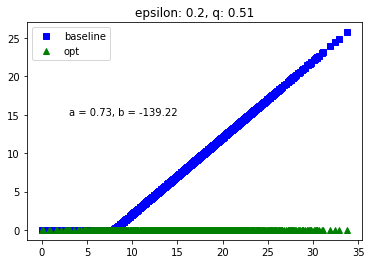

In [234]:
# np.random.seed(1)
train_y, train_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=100)
eval_y, eval_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=20)
test_y, test_x = make_single_zone_data(beta=3,mu=5,sigma=2,n=1000)


pred_model = LinearRegression().fit(train_x,train_y)
model_predictions = pred_model.predict(train_x)
strike_p, strike_val = determine_strike_value(train_y,eval_y,eval_x,pred_model)

epsilon = 0.2
loss_quantile = 0.51
a,b = min_premium_program(model_predictions,train_y,loss_quantile,epsilon,'full')
a,b = np.around((a,b),2)
print('a: {}, b: {}'.format(a,b))

bdf, odf = make_eval_dfs(test_x,test_y,pred_model,strike_val,a,b)
plt.plot(bdf['PredictedLosses'],bdf['Payout'],'bs',label='baseline')
plt.plot(odf['PredictedLosses'],odf['Payout'],'g^',label='opt')
plt.title('epsilon: {}, q: {}'.format(epsilon,loss_quantile))
plt.text(3,15,'a = {}, b = {}'.format(a,b))
plt.legend()
plt.show()

In [180]:
 judge_groups = np.array_split(judge_ids,np.arange(10,len(judge_ids),10))
    i = 0
    for group in judge_groups:
        fig, axes = plt.subplots(5,2,figsize=(10,10))
        for judge, ax in zip(group,axes.ravel()):
            normal_judge = judges[judge]
            normal_judge.plot_convex_hull(ax)
            ax.set_title(judge)

        plt.tight_layout()

array([0.5   , 0.5875, 0.675 , 0.7625, 0.85  ])

In [274]:
args = ('eps',1,'bla',2)
'{}:{}, {}:{}'.format(*args)

'eps:1, bla:2'

eps: 0.1, premium: 0.45
eps: 0.2, premium: 0.45
eps: 0.3, premium: 0.45
eps: 0.4, premium: 0.45
eps: 0.5, premium: 0.45
eps: 0.1, premium: 0.45
eps: 0.2, premium: 0.45
eps: 0.3, premium: 0.45
eps: 0.4, premium: 0.45
eps: 0.5, premium: 0.45
eps: 0.1, premium: 0.45
eps: 0.2, premium: 0.45
eps: 0.3, premium: 0.45
eps: 0.4, premium: 0.45
eps: 0.5, premium: 0.45


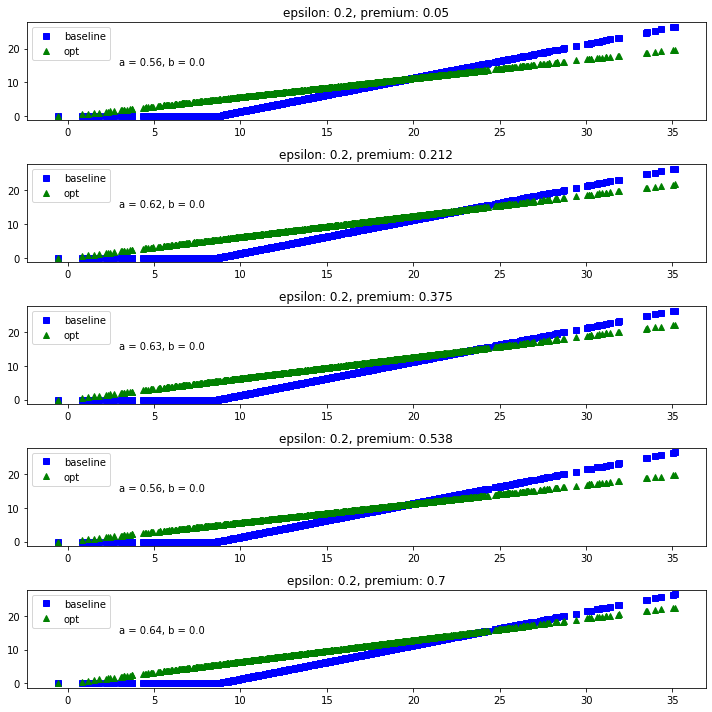

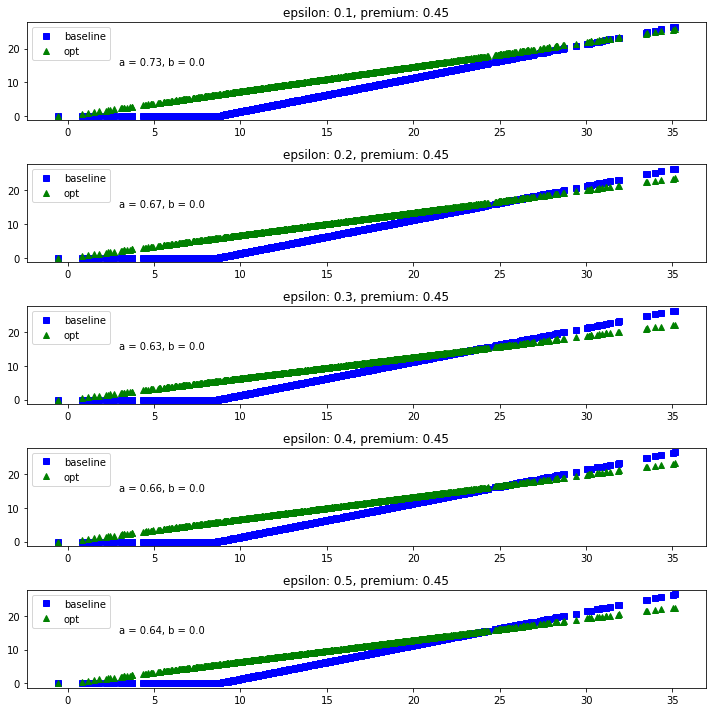

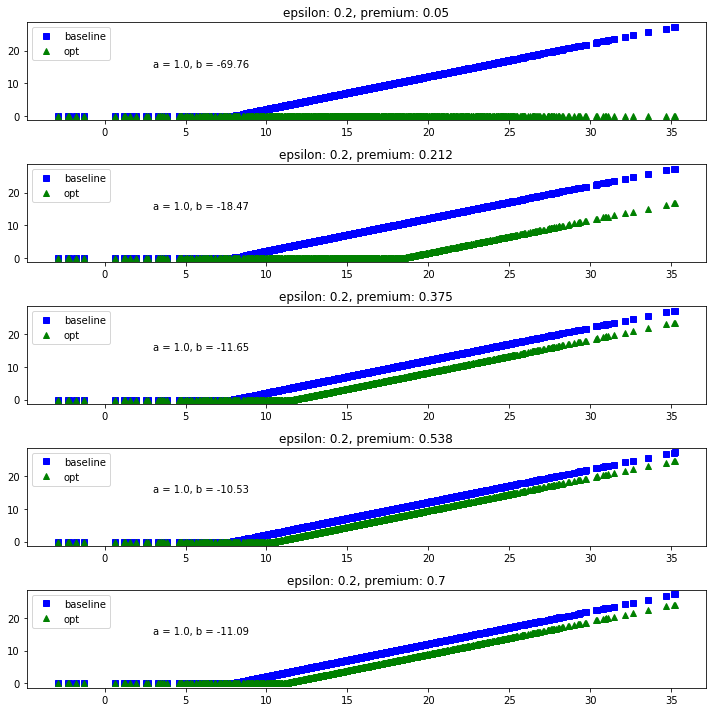

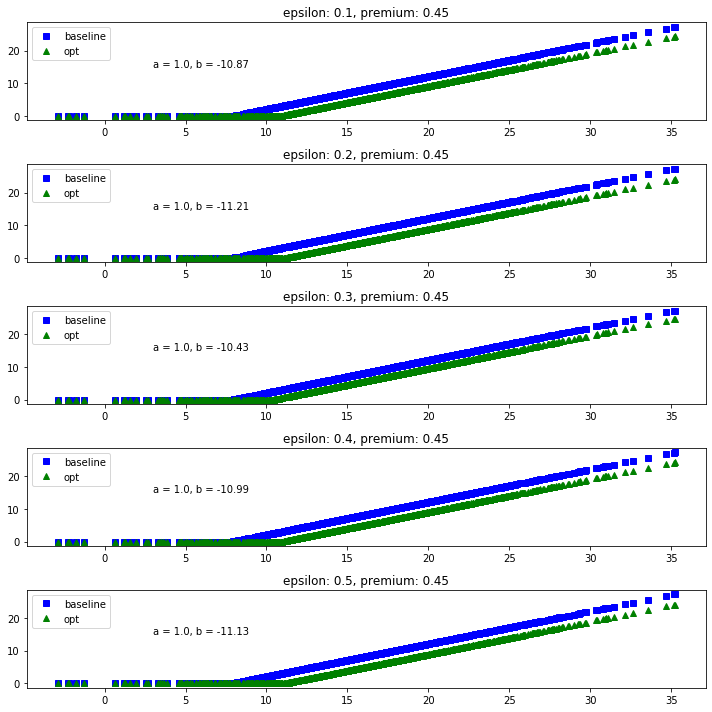

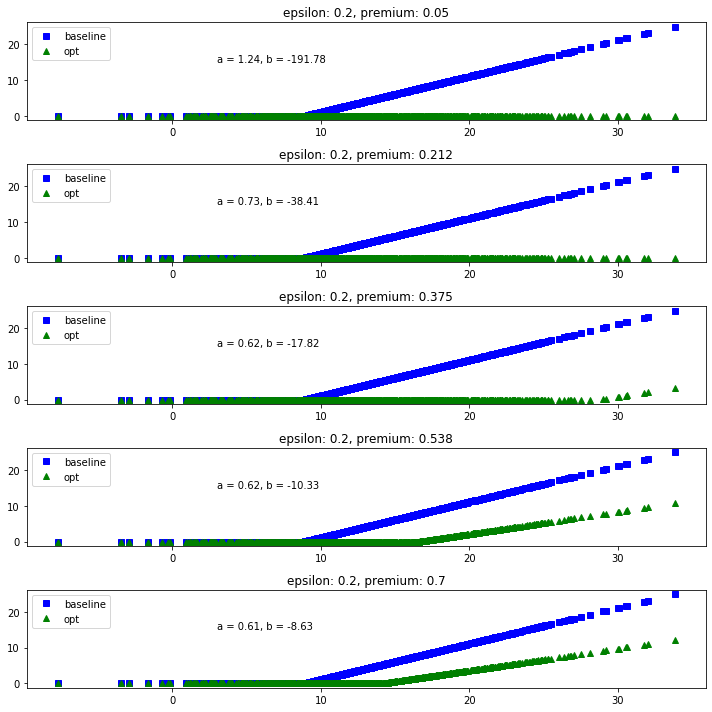

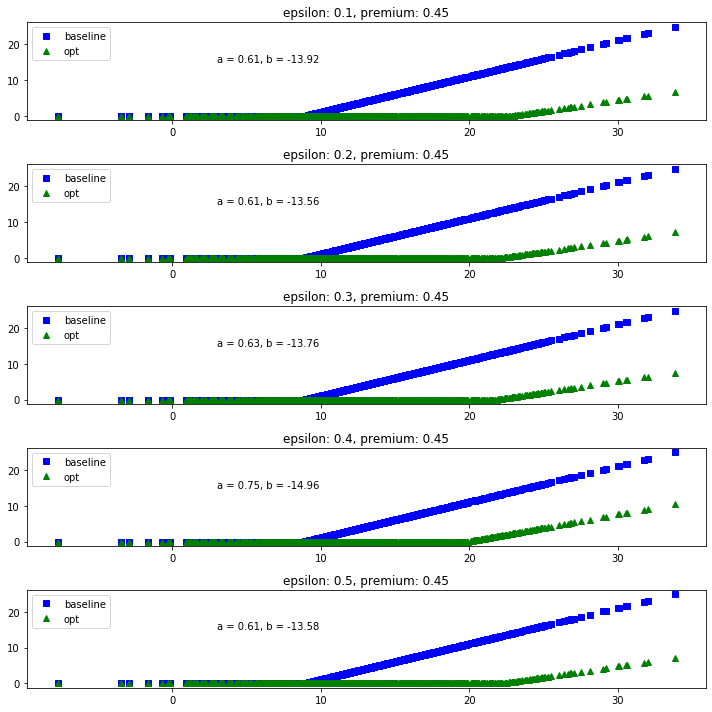

In [295]:
CVaR_program_exploration('slope')
CVaR_program_exploration('intercept')
CVaR_program_exploration('full')